In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Разобьем выборку на тест и трейн

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

### Your code is here
pipe_lr = Pipeline([('scaler', MinMaxScaler()),
                    ('logreg', LogisticRegression())])
pipe_svm = Pipeline([('scaler', MinMaxScaler()),
                    ('linear_svc', LinearSVC())])


In [6]:
### Обучаем модели на трейне
### Your code is here
pipe_lr.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)


Pipeline(steps=[('scaler', MinMaxScaler()), ('linear_svc', LinearSVC())])

In [10]:
pipe_lr.score(X_test,y_test)

0.8427743737234796

In [11]:
pipe_svm.score(X_test,y_test)

0.84039848276437

Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок [0;1] и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


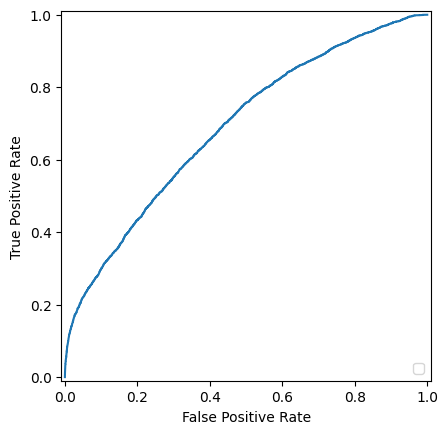

In [24]:
### С изображением рок-кривой для ЛогРега не будет проблем:
### Your code is here
fpr, tpr, thresholds = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [25]:
roc_auc = auc(fpr, tpr)
print(round(roc_auc,3))

0.689


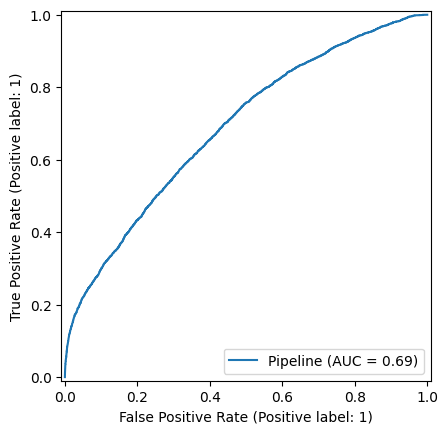

In [26]:
RocCurveDisplay.from_estimator(pipe_lr, X_test, y_test)

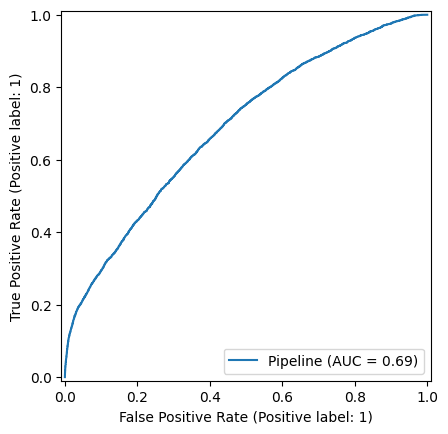

In [27]:
RocCurveDisplay.from_estimator(pipe_svm, X_test, y_test)

In [28]:
from sklearn.metrics import roc_curve
y_score = pipe_svm.decision_function(X_test)

# Вычисление значений FPR и TPR
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Вычисление площади под ROC-кривой
roc_auc = auc(fpr, tpr)
print(round(roc_auc,3))

0.688


In [30]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function

### Your code is here
# pipe_svm.decision_function(X_test.head(2))
# 
# def sigmoid(output):
#     return 1 / (1 + np.exp(-output))
# 
# 
# pred_prob = sigmoid(pipe_svm.decision_function(X_test))

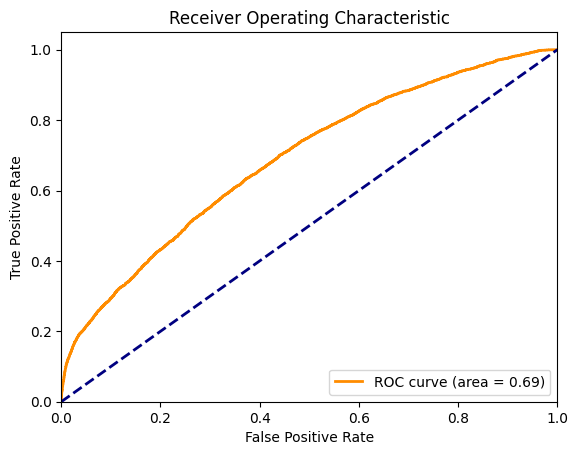

In [21]:
decision_values = pipe_svm.decision_function(X_test)

# Преобразование decision_function в вероятности
probabilities = (decision_values - decision_values.min()) / (decision_values.max() - decision_values.min())

# Рассчитываем ROC-кривую и AUC для SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, probabilities)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Рисуем ROC-кривую
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [3]:
from sklearn.metrics import auc 

### Your code is here




Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

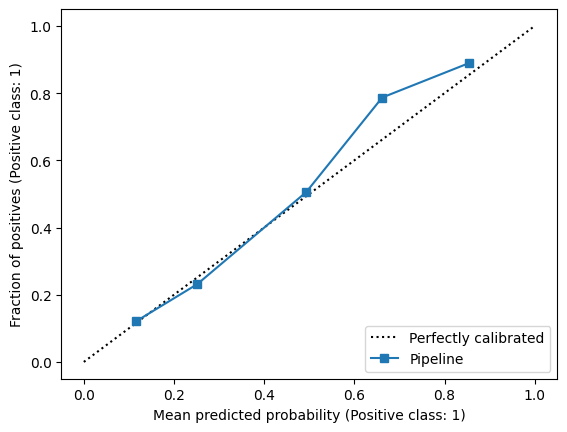

In [31]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay

### Your code is here
CalibrationDisplay.from_estimator(pipe_lr, X_test, y_test)



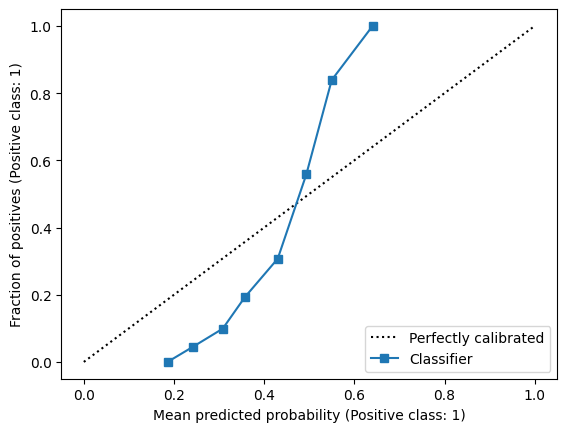

In [33]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
pipe_svm.decision_function(X_test.head(2))

def sigmoid(output):
    return 1 / (1 + np.exp(-output))


pred_prob = sigmoid(pipe_svm.decision_function(X_test))

### Your code is here
CalibrationDisplay.from_predictions(y_test, pred_prob, n_bins=15)



**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [34]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

### Your code is here

calibration = CalibratedClassifierCV(pipe_svm, cv=5, method='sigmoid')
calibration.fit(X_train, y_train)

calibrated_probs = calibration.predict_proba(X_test)[:, 1]

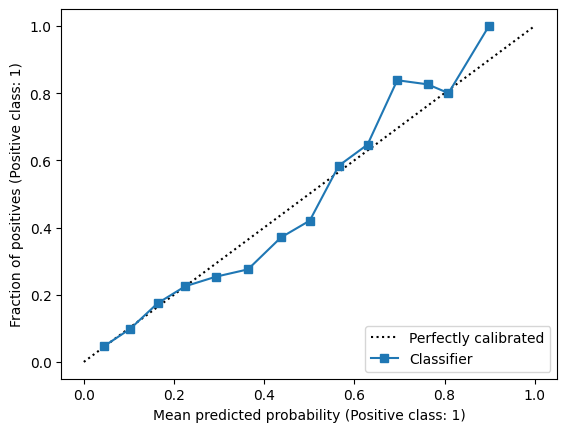

In [35]:
### Новая кривая

### Your code is here
CalibrationDisplay.from_predictions(y_test, calibrated_probs, n_bins=15)



In [36]:
calibration1 = CalibratedClassifierCV(pipe_svm, cv=5, method='isotonic')
calibration1.fit(X_train, y_train)

calibrated_probs1 = calibration1.predict_proba(X_test)[:, 1]

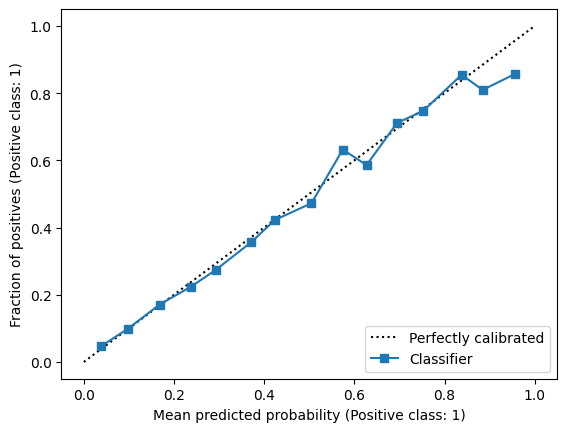

In [37]:
CalibrationDisplay.from_predictions(y_test, calibrated_probs1, n_bins=15)

try func

In [40]:
pipe_svm.decision_function(X_test.head(10))


array([-0.55389762, -0.67142269, -0.74559609, -0.61736633, -0.82718187,
       -0.53915082, -0.74397081, -0.07014192, -0.58250962, -0.51686684])